# Please Install these Dependencies

In [3]:
!pip install tensorflow==2.5.0
!pip install gym
!pip install keras
!pip install keras-rl2

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
jupyter-server 1.13.5 requires pywinpty<2; os_name == "nt", but you have pywinpty 2.0.2 which is incompatible.
bokeh 2.4.2 requires typing-extensions>=3.10.0, but you have typing-extensions 3.7.4.3 which is incompatible.



  Using cached tensorflow-2.5.0-cp39-cp39-win_amd64.whl (422.6 MB)
  Using cached h5py-3.1.0-cp39-cp39-win_amd64.whl (2.7 MB)
  Using cached grpcio-1.34.1-cp39-cp39-win_amd64.whl (2.9 MB)
  Using cached absl_py-0.15.0-py3-none-any.whl (132 kB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached tensorflow_estimator-2.5.0-py2.py3-none-any.whl (462 kB)
  Using cached numpy-1.19.5-cp39-cp39-win_amd64.whl (13.3 MB)
  Using cached six-1.15.0-py2.py3-none-any.whl (10 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.1.1
    Uninstalling typing_extensions-4.1.1:
      Successfully uninstalled typing_extensions-4.1.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.10.0
    Uninstalling tensorflow-estimator-2.10.0:
      Successfully uninstalled tensorflow-estimator-2.10.0
  Attempting uninstall: flatbuff

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.5.0 requires daal==2021.4.0, which is not installed.
bokeh 2.4.2 requires typing-extensions>=3.10.0, but you have typing-extensions 3.7.4.3 which is incompatible.


#  Build Environment

In [1]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import random

In [2]:
random.seed(22)

### The Vehicle Class contains all the information for the DQN Agent (step, reset, rewards, etc.)

In [252]:
class VehEnv(Env):
    def __init__(self,visualize,traffic_lights,mass,frontal_area,air_density,drag_cof,Crr):
        self.traffic_lights = traffic_lights
        self.mass = mass
        self.frontal_area = frontal_area
        self.air_density = air_density
        self.drag_cof = drag_cof
        self.Crr = Crr
   
        
        # number of actions (accelerations)- Discrete is discrete set of values
        self.action_space = Discrete(11)                         
        # upper and lower bounds for speed- Box is continuous set of values- normalize?
        self.observation_space = Box(low=np.array([0.0, 0.0, 0.0,0]), high = np.array([40.0/40.0, 1000/1000,40/40,1])) 
        
        # parameters for normilization
        self.speed_max = 40
        self.dist_max = 1000
        self.time_max = 40
        
        
        # start parameters
        self.power = 0
        self.energy = 0
        self.traffic_lights.reset()
        next_pos = self.traffic_lights.get_info()[0][0]
        self.prev_light_pos = self.traffic_lights.get_info()[0][0]
        next_phase = self.traffic_lights.get_info()[0][3]
        if next_phase == 0:
             next_time = self.traffic_lights.get_info()[0][2]
        else:
            next_time = self.traffic_lights.get_info()[0][1]
        self.x = 0 
        self.state = [self.normalize(self.speed_max,random.randint(0,35)), self.normalize(self.dist_max,next_pos),self.normalize(self.time_max,next_time), next_phase]

        # set simulation length
        self.sim_length = 1000
        
        self.vis = visualize
        if self.vis:
            global speeds 
            global accel
            global light_vis_info
            global total_energy
            speeds = []
            accels = []
            position = []
            light_vis_info = []
            total_energy = []
            
        else:
            pass

        
        
        
    def step(self,action):
        reward = 0
        
        # map discrete values to discrete acceleration values  between -3 and 2 (y=0.5x-2)
        accel = 0.5*action-3
        # get previous state
        prev_speed = (self.state[0]*self.speed_max/2)+self.speed_max/2
        prev_x = self.x
        # get new speed and position and SPaT data
        speed = prev_speed+ accel
        self.x = prev_x + prev_speed+(speed-prev_speed)/2
        
        # collect data for ran red function
        prev_phase = self.state[3] # previous phase 

        # change traffic lights
        self.traffic_lights.step()
        
        # calculate energy
        [energy,power] = self.power_calcs(accel,speed)
        self.energy += energy
        self.power = power
        
        # drop simulation time every time step
        self.sim_length -= 1
        
        # check next light info
        y = self.check_next_light(self.x)
        next_light_pos = self.traffic_lights.get_info()[y][0]
        next_pos = next_light_pos-self.x
        next_phase = self.traffic_lights.get_info()[y][3]
        if next_phase == 0:
             next_time = self.traffic_lights.get_info()[y][2]
        else:
            next_time = self.traffic_lights.get_info()[y][1]
        
        # check if light was ran
        if self.prev_light_pos !=  next_light_pos:
            reward += self.ran_red(prev_phase)
    
        # only do this if visualization is necessary 
        if self.vis:
            speeds.append(speed)
            accels.append(accel)
            positions.append(self.x)
            total_energy.append(self.energy)
            info = self.traffic_lights.get_info()
            lights_at_time_step = []
            for i in range(0,len(info)):   
                lights_at_time_step.append([info[i][0],info[i][3]])
            light_vis_info.append(lights_at_time_step)
        else:
            pass     
        
        # reward function
#         error = (speed-25)**2
#         reward = reward + -2/(1+2.7**(-0.05*error))+2
        reward = reward + 1/(2.7**(0.5*accel**2))
        
    
        # check if simulation is done
        last_light = self.traffic_lights.get_info()[len(self.traffic_lights.get_info())-1][0]
        if self.sim_length <= 0 or speed < 0 or self.x >= last_light or reward < 0:
            done = True
        else:
            done = False
            
    
        # return step information
        self.prev_light_pos = next_light_pos
        self.state = [self.normalize(self.speed_max,speed), self.normalize(self.dist_max,next_pos),self.normalize(self.time_max,next_time), next_phase]
        info = {}
        return self.state, reward, done, info
     
        
        
        
    def ran_red(self,prev_phase):
        # the light could turn green or red at an interval we don't check... this will be fixed later
        # the light will only check at the last phase before vehicle passes through
        if prev_phase == 1:
            # did not ran red
            return 10
        elif prev_phase == 0:
            # ran red
            return -10
            
            
            
            
    def power_calcs(self,accel,speed):
        drag = 0.5*self.drag_cof*self.frontal_area*self.air_density*speed**2
        rolling_res = mass*9.81*Crr ###Fix
        force = self.mass*accel + drag + rolling_res
        power = force*speed/1000 # convert to kW
        if power < 0:
            power = 0
        
        energy = self.energy+self.power+(power-self.power)/2
        energy = energy*0.000277778 # convert from kJ to kWh
        return energy, power
        
        
        
    
    def check_next_light(self,x):
        c = self.traffic_lights.get_info()
        if x < c[0][0]:
            y = 0
        if x > c[len(c)-1][0]:
            y = len(c)-1
        else:
            for i in range(0,len(c)-1):
                if x >= c[i][0] and x <= c[i+1][0]:
                    y = i + 1
        return y
        
        
        
        
    def normalize(self,max,x):
        normed = (x-max/2)/(max/2)
        return normed
        
        
        
        
    def render(self):
        pass
    
    
    
    
    def reset(self):
        
#         reset initial conditions
        self.power = 0
        self.energy = 0

        self.traffic_lights.reset()
        next_pos = self.traffic_lights.get_info()[0][0]
        next_phase = self.traffic_lights.get_info()[0][3]
        if next_phase == 0:
             next_time = self.traffic_lights.get_info()[0][2]
        else:
            next_time = self.traffic_lights.get_info()[0][1]
        self.x = 0
        self.state = [self.normalize(self.speed_max,random.randint(0,35)), self.normalize(self.dist_max,next_pos),self.normalize(self.time_max,next_time), next_phase]
        
        # reset time
        self.sim_length = 1000
        if self.vis:
            speeds = []
            accels = []
            positions = []
            light_vis_info = []
            total_energy = []
        else:
            pass
        
        return self.state
        

### This Traffic Light Class creates a single Traffic Light with Signal Phasing and Timing Data 

In [253]:
class TrafficLight():
    def __init__(self,position,green_time,red_time):
        # green is 1, red is 0
        self.initial_green_time = green_time
        self.initial_red_time = red_time
        self.initial_position = position
        self.position = position
        self.green_time = green_time
        self.red_time = red_time
        self.phase =random.randint(0,1)
    
    def reset(self):
        self.position = self.initial_position
        self.green_time = self.initial_green_time
        self.red_time = self.initial_red_time
        self.phase = random.randint(0,1)

    def step(self):
        if self.phase == 1:
            self.green_time -= 1
        elif self.phase == 0:
            self.red_time -= 1

        if self.green_time <= 0:
            self.phase = 0
            self.green_time = self.initial_green_time
        elif self.red_time <= 0:
            self.phase = 1
            self.red_time = self.initial_red_time
        return None
    
    def get_info(self): 
        return [self.position, self.green_time, self.red_time,self.phase]

### This Corridor Class builds an entire Street of Lights using the previous Traffic Light Class

In [254]:
class Corridor():
    def __init__(self,*args):
        self.y = [x for x in args]
        
    def step(self):
        for x in self.y:
            x.step()
            
    def reset(self):
        for x in self.y:
            x.reset()
        
    def get_info(self):
        return [x.get_info() for x in self.y]

# Vehicle Parameters

In [255]:
## user input
# mass = input('Vehicle Mass in kg: ')
# frontal_area = input('Frontal area of vehicle in m^2: ')
# air_density =  input('Density of air in kg/m^3: ')
# drag_cof = input('Drag Coefficient: ')

# pre-defined
mass = 2050 
frontal_area = 2
air_density = 1.2
drag_cof = .38
Crr = .01


# Test that Traffic Light and Corridor Classes are functioning properly

In [256]:
### # Test light class
# TL = TrafficLight(20,30,25)    # position, green_time, red_time
# for i in range(1,920):
#     TL.step()
# print(TL.get_info())
# TL1 = TrafficLight(20,3,25) 
# TL2 = TrafficLight(20,30,25) 
# TL3 = TrafficLight(20,40,25) 

In [257]:
# # Test corridor class
# c = Corridor(TL1,TL2,TL3)
# print(c.get_info())
# for i in range(1,20):
#     c.step()
# print(c.get_info())

# Build Traffic Light Corridor

In [258]:
# build traffic light corridor
TL1 = TrafficLight(500,25,40) 
TL2 = TrafficLight(1000,35,30) 
TL3 = TrafficLight(1500,40,30) 
TL4 = TrafficLight(3000,35,40)
TL5 = TrafficLight(3500,35,40)
TL6 = TrafficLight(4000,35,40)
TL7 = TrafficLight(5000,35,40)

TL8 = TrafficLight(6000,25,40) 
TL9 = TrafficLight(7000,35,30) 
TL10 = TrafficLight(10000,40,30) 
TL11= TrafficLight(11000,35,40)
TL12= TrafficLight(12000,35,40)
TL13= TrafficLight(13000,35,40)
TL14= TrafficLight(14000,35,40)

corridor = Corridor(TL1,TL2,TL3,TL4,TL5,TL6,TL7,TL8,TL9,TL10,TL11,TL12,TL13,TL14)
# build environment
env = VehEnv(False, corridor,mass,frontal_area,air_density,drag_cof,Crr)
corridor.get_info()

C:\Users\bking\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[[500, 25, 40, 1],
 [1000, 35, 30, 1],
 [1500, 40, 30, 0],
 [3000, 35, 40, 0],
 [3500, 35, 40, 0],
 [4000, 35, 40, 0],
 [5000, 35, 40, 0],
 [6000, 25, 40, 0],
 [7000, 35, 30, 0],
 [10000, 40, 30, 0],
 [11000, 35, 40, 1],
 [12000, 35, 40, 0],
 [13000, 35, 40, 0],
 [14000, 35, 40, 0]]

## Verify environment is returning appropriate results

In [259]:
env.observation_space.sample()

array([0.29321486, 0.00856887, 0.6782398 , 0.76046777], dtype=float32)

In [260]:
## Testing car matches with matlab and other Python model
# state = env.reset()
# done = False
# score = 0
# for i in range(1,21):
#     action = env.step(10)
    
    

In [261]:
episodes = 1
for episode in range(1,episodes+1):
    state = env.reset()
    done = False
    score = 0
    
    while not done:
        env.render()
        action = env.action_space.sample()  
        n_state, reward, done, info = env.step(action)
        score+= reward
        print(n_state)
    print('Episode:{} Score:{}'.format(episode,score))
    


[-0.375, -0.0265, 0.2, 1]
[-0.375, -0.0515, 0.15, 1]
[-0.5, -0.074, 0.1, 1]
[-0.425, -0.0955, 0.05, 1]
[-0.55, -0.116, 0.0, 1]
[-0.55, -0.134, -0.05, 1]
[-0.575, -0.1515, -0.1, 1]
[-0.575, -0.1685, -0.15, 1]
[-0.7, -0.183, -0.2, 1]
[-0.7, -0.195, -0.25, 1]
[-0.75, -0.206, -0.3, 1]
[-0.725, -0.2165, -0.35, 1]
[-0.8, -0.226, -0.4, 1]
[-0.875, -0.2325, -0.45, 1]
[-0.85, -0.238, -0.5, 1]
[-0.9, -0.243, -0.55, 1]
[-0.925, -0.2465, -0.6, 1]
[-1.025, -0.2475, -0.65, 1]
Episode:1 Score:10.330428047403254


# Build DQN Model

In [104]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow import keras

In [105]:
states = env.observation_space.shape
actions = env.action_space.n

In [106]:
def build_model(states, actions):
    model = Sequential()
    model.add(Flatten(input_shape=(1,states[0])))
    model.add(Dense(128, activation='relu', input_shape = (1,states[0])))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(actions, activation ='linear'))
    return model

In [107]:
try:
    del model
except:
    pass

In [108]:
model = build_model(states, actions)

In [109]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               640       
_________________________________________________________________
dense_13 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_14 (Dense)             (None, 11)                1419      
Total params: 18,571
Trainable params: 18,571
Non-trainable params: 0
_________________________________________________________________


# Build Agent 

In [110]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

### Load a Saved Model

In [111]:
# model = keras.models.load_model('Random_Lights_Long_Working_Model_Long_Training')

### Build and compile agent

In [112]:
def build_agent(model, acitons):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=100000, window_length =1)
    dqn = DQNAgent(model=model, memory=memory, policy= policy, nb_actions=actions, nb_steps_warmup=10, target_model_update = 1e-2)
    return dqn

In [113]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics = ['mae'])

C:\Users\bking\anaconda3\lib\site-packages\tensorflow\python\keras\optimizer_v2\optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


### Create a New Model (do not run if simply using the loaded saved model)

In [114]:
history = dqn.fit(env, nb_steps =500000, visualize=False, verbose =1)

Training for 500000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 17:35 - reward: 0.8832

C:\Users\bking\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
C:\Users\bking\anaconda3\lib\site-packages\rl\memory.py:37: UserWarning: Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!
  warnings.warn('Not enough entries to sample without replacement. Consider increasing your warm-up phase to avoid oversampling!')


10000/10000 [==============================] - 43s 4ms/step - reward: 0.7150
141 episodes - episode_reward: 48.984 [-9.989, 502.592] - loss: 11.505 - mae: 37.331 - mean_q: 44.203

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 48s 5ms/step - reward: 0.7585
34 episodes - episode_reward: 225.050 [-9.989, 688.181] - loss: 32.576 - mae: 91.035 - mean_q: 106.022

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 54s 5ms/step - reward: 0.7532
28 episodes - episode_reward: 258.643 [-9.989, 607.849] - loss: 42.642 - mae: 125.717 - mean_q: 145.708

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 57s 6ms/step - reward: 0.7663
26 episodes - episode_reward: 307.377 [-9.863, 630.330] - loss: 43.712 - mae: 138.956 - mean_q: 161.038

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 54s 5ms/step - reward: 0.7631
23 episodes - episode_reward: 313.229 [-9.863, 652.457] - 

10000/10000 [==============================] - 65s 7ms/step - reward: 0.7215
28 episodes - episode_reward: 244.291 [-9.989, 713.561] - loss: 16.664 - mae: 125.042 - mean_q: 139.536

Interval 39 (380000 steps performed)
10000/10000 [==============================] - 60s 6ms/step - reward: 0.7134
21 episodes - episode_reward: 348.802 [-9.989, 749.424] - loss: 17.755 - mae: 123.051 - mean_q: 137.408

Interval 40 (390000 steps performed)
10000/10000 [==============================] - 59s 6ms/step - reward: 0.7307
20 episodes - episode_reward: 380.469 [-9.989, 737.155] - loss: 17.835 - mae: 123.150 - mean_q: 137.583

Interval 41 (400000 steps performed)
10000/10000 [==============================] - 60s 6ms/step - reward: 0.7223
20 episodes - episode_reward: 366.494 [-9.989, 707.246] - loss: 17.116 - mae: 121.867 - mean_q: 136.026

Interval 42 (410000 steps performed)
10000/10000 [==============================] - 61s 6ms/step - reward: 0.7381
13 episodes - episode_reward: 530.476 [-9.989, 

### Save Model to current directory

In [ ]:
# model.save('model-acceleration_basedsd')

### Show training stats and neural network weights/biases

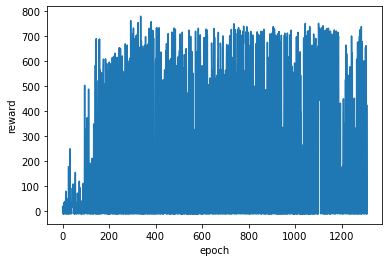

In [268]:
# summarize history for accuracy
plt.plot(history.history['episode_reward'])
plt.ylabel('reward')
plt.xlabel('epoch')
plt.show()
# model.get_weights()

## Simulate 10 Episodes

In [262]:
scores = dqn.test(env, nb_episodes = 10, visualize=False)
print(np.mean(scores.history['episode_reward']))

Testing for 10 episodes ...
Episode 1: reward: 233.825, steps: 265
Episode 2: reward: -9.117, steps: 1
Episode 3: reward: 969.161, steps: 1000
Episode 4: reward: -9.117, steps: 1
Episode 5: reward: 951.019, steps: 1000
Episode 6: reward: 945.906, steps: 1000
Episode 7: reward: -9.391, steps: 1
Episode 8: reward: 885.033, steps: 959
Episode 9: reward: 938.605, steps: 1000
Episode 10: reward: 940.884, steps: 964
583.6806410782044


# Visualize Data

In [270]:
import matplotlib.pyplot as plt

### Build Env for Visualization

In [271]:
env_vis = VehEnv(True,corridor,mass,frontal_area,air_density,drag_cof,Crr)

C:\Users\bking\anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


### Simulate 1 Run with Visualizations

In [272]:
speeds = []
accels = []
positions = []
test1 = dqn.test(env_vis, nb_episodes = 1, visualize=False)

Testing for 1 episodes ...
Episode 1: reward: 934.355, steps: 1000


In [273]:
y=np.array(list(range(len(speeds))))

<function matplotlib.pyplot.show(close=None, block=None)>

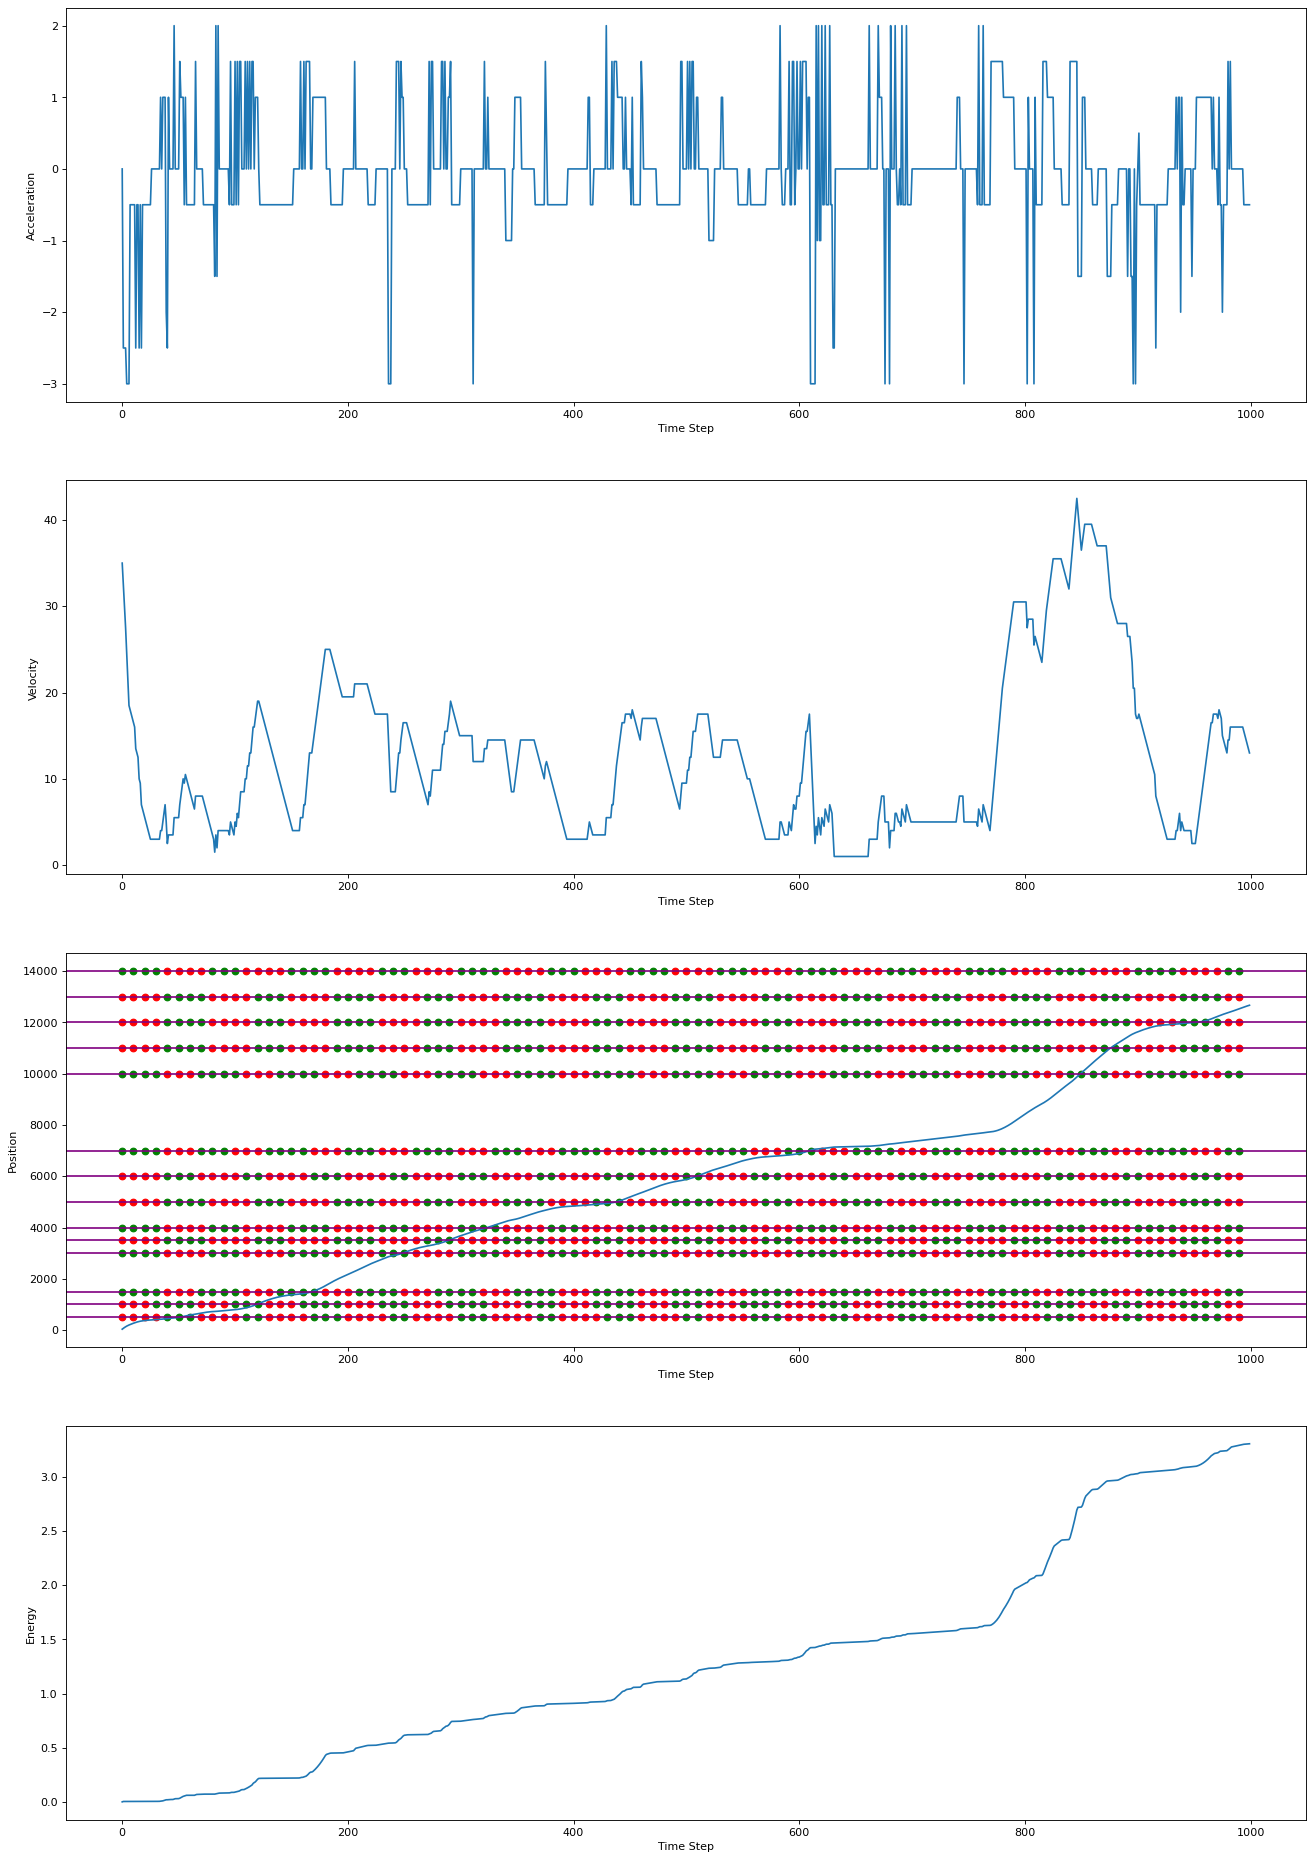

In [274]:
plt.figure(1,figsize=(20, 30), dpi=80)

plt.subplot(4,1,1)
plt.plot(y,accels)
plt.xlabel("Time Step")
plt.ylabel("Acceleration")

plt.subplot(4,1,2)
plt.plot(y,speeds)
plt.xlabel("Time Step")
plt.ylabel("Velocity")

plt.subplot(4,1,3)
plt.plot(y,positions)
for i in range(0,len(corridor.get_info())):
    plt.axhline(corridor.get_info()[i][0],color='purple')
for i in range(0,len(positions),10):
    for j in range(0,len(light_vis_info[i])):
        if light_vis_info[i][j][1] == 1:
            plt.scatter(i,light_vis_info[i][j][0],color="green" )
        if light_vis_info[i][j][1] == 0:
            plt.scatter(i,light_vis_info[i][j][0],color="red" )   
plt.xlabel("Time Step")
plt.ylabel("Position")

plt.subplot(4,1,4)
plt.plot(y,total_energy)
plt.xlabel("Time Step")
plt.ylabel("Energy")

plt.show